# HEV Spare Parts Price Classification

_Final consolidated pipeline mirroring the demand workflow for price tiers_

## Environment & Imports

In [1]:

import warnings
warnings.filterwarnings("ignore")

import sys
import subprocess
import platform
import os
import json
import itertools
import hashlib
from pathlib import Path

sys.path.append(str(Path('src').resolve()))


def _ensure_import(module_name, pip_name=None):
    try:
        return __import__(module_name)
    except ModuleNotFoundError:
        pkg = pip_name or module_name
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg, '-q'])
        return __import__(module_name)


_ensure_import('seaborn', 'seaborn')
_ensure_import('sklearn', 'scikit-learn')
_ensure_import('numpy', 'numpy')
_ensure_import('pandas', 'pandas')
_ensure_import('matplotlib', 'matplotlib')

system = platform.system()
machine = platform.machine().lower()
tf_pkg = 'tensorflow'
if system == 'Windows':
    tf_pkg = 'tensorflow-cpu'
elif system == 'Darwin' and 'arm' in machine:
    tf_pkg = 'tensorflow-macos'
_ensure_import('tensorflow', tf_pkg)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupShuffleSplit, GroupKFold, StratifiedKFold, StratifiedShuffleSplit, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

os.environ["TF_DETERMINISTIC_OPS"] = "1"

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


## Configuration

In [2]:
from pathlib import Path
from utils.feature_config import (
    BASE_BLOCKLIST,
    sanitize_feature_lists,
    save_feature_metadata,
    load_feature_metadata,
)

# Include 'part' as a feature (still used for grouping)
DROP_PART = False

# Feature/blocklist configuration
BLOCKLIST_FEATURES = set(BASE_BLOCKLIST)
# No special whitelist for ratio features

LEAKAGE_F1_THRESHOLD = 0.85
PERSIST_FEATURE_METADATA = True
ARTIFACTS_METADATA_PATH = Path('src') / 'artifacts' / 'price_model_metadata.json'


# ANN hyperparameter grid (identical to demand workflow; 72 combinations)
GRID = {
    'num_layers':    [1, 2, 3],
    'units':         [16, 32],
    'dropout_rate':  [0.0, 0.2],
    'l2_reg':        [0.0, 1e-4],
    'learning_rate': [1e-3, 3e-3, 1e-2],
}

# Small grids for the classical models (kept in sync with demand notebook)
GRIDS_CLASSIC = {
    "svc_rbf": {"C": [1.0, 3.0], "gamma": ["scale", "auto"]},
    "logreg":  {"C": [0.3, 1.0, 3.0], "solver": ["lbfgs"], "max_iter": [2000]},
    "et":      {"n_estimators": [200, 400], "max_depth": [None, 20]},
    "sgd":     {"loss": ["log_loss"], "alpha": [1e-4, 1e-3], "max_iter": [2000], "random_state": [SEED]},
    "lda":     {"solver": ["svd"]},
}

MODEL_ZOO = {
    "svc_rbf": {
        "label": "SVC (RBF)",
        "factory": lambda p: SVC(**p),
        "style": "scale",
    },
    "logreg": {
        "label": "LogisticRegression",
        "factory": lambda p: LogisticRegression(multi_class="multinomial", **p),
        "style": "scale",
    },
    "et": {
        "label": "ExtraTrees",
        "factory": lambda p: ExtraTreesClassifier(random_state=SEED, n_jobs=-1, **p),
        "style": "tree",
    },
    "sgd": {
        "label": "SGDClassifier (log_loss)",
        "factory": lambda p: SGDClassifier(**p),
        "style": "scale",
    },
    "lda": {
        "label": "LinearDiscriminantAnalysis",
        "factory": lambda p: LDA(**p),
        "style": "scale",
    },
}
MODEL_KEYS = ["svc_rbf", "logreg", "et", "sgd", "lda"]



### TODOs
- [ ] Explore leakage-safe replacements for removed price-derived ratios (e.g., aggregate pricing by vehicle class).
- [ ] Investigate automated feature-pattern rules beyond `BLOCKLIST_FEATURES` (e.g., regex on column names) before ingesting future datasets.
- [ ] Monitor the leakage audit threshold after collecting more data to ensure 0.90 remains a sensible guard rail.


## Data Loading & Profiling

In [3]:
# Data cleanup for the new dataset (self-contained; safe if df already exists)
import os
from pathlib import Path
import numpy as np
import pandas as pd

# Ensure df exists (load like the data-loading cell if not already loaded)
if 'df' not in globals():
    price_env = os.environ.get("PRICE_DATA_PATH", "").strip()
    candidates = [Path(price_env)] if price_env else []
    candidates += [
        Path("data") / "Price.csv",
        Path("..") / "data" / "Price.csv",
    ]
    file_path = next((p for p in candidates if p.exists()), None)
    if file_path is None:
        raise FileNotFoundError(
            "Could not find Price.csv. Set PRICE_DATA_PATH or place the file in data/ or ../data/."
        )
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip()
    print("Loaded:", file_path.resolve())

# Force numeric dtypes for these columns (target 'price' kept numeric but excluded from features later)
numeric_cols_force = [
    'number of cars in jordan',
    'car age',
    'failure rate',
    'price of the car',
    'repair or replacement cost',
    'car total maintenance cost average',
    'critically',
    'online price',
    'price',  # target
]

for c in numeric_cols_force:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Replace inf/-inf with NaN and drop rows with missing target
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna(subset=['price']).reset_index(drop=True)

# Optional guard: drop any hard-blocklisted leakage columns if present (none expected here)
try:
    _ = BLOCKLIST_FEATURES
except NameError:
    BLOCKLIST_FEATURES = set()

existing_leakage_columns = sorted(set(BLOCKLIST_FEATURES).intersection(df.columns))
if existing_leakage_columns:
    print(f"Dropping leakage-prone columns: {existing_leakage_columns}")
    df = df.drop(columns=existing_leakage_columns)

print("Shape after cleanup:", df.shape)
print("Columns available:", list(df.columns))


Loaded: /Users/yaeesh/hev-spareparts-ml/data/Price.csv
Dropping leakage-prone columns: ['online price']
Shape after cleanup: (7652, 15)
Columns available: ['car type', 'made in', 'number of cars in jordan', 'car age', 'part', 'failure rate', 'price of the car', 'original/imitator', 'new\\used', 'selling location', 'service location (repair shop/automotive company', 'repair or replacement cost', 'car total maintenance cost average', 'critically', 'price']


In [4]:
# Feature engineering derived from domain ratios
epsilon = 1e-6
with np.errstate(divide='ignore', invalid='ignore'):
    df['repair_to_car_price'] = df['repair or replacement cost'] / (df['price of the car'] + epsilon)
    df['repair_to_price'] = df['repair or replacement cost'] / (df['price'] + epsilon)

df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop any hard-blocklisted leakage columns if they slipped through (e.g., on line price)
existing_leakage_columns = sorted(set(BLOCKLIST_FEATURES).intersection(df.columns))
if existing_leakage_columns:
    print(f"Dropping leakage-prone columns derived from target: {existing_leakage_columns}")
    df = df.drop(columns=existing_leakage_columns)


## Feature Taxonomy

In [5]:
# Categorical and numeric feature candidates from the new dataset
cat_cols_raw = [
    'car type',
    'made in',
    'original/imitator',
    r'new\used',
    'selling location',
    'service location (repair shop/automotive company',
    'part',
]

num_cols_raw = [
    'number of cars in jordan',
    'car age',
    'failure rate',
    'price of the car',
    'repair or replacement cost',
    'car total maintenance cost average',
    'critically',
    'online price',
    # NOTE: 'price' is the target and is intentionally excluded
]

# Sanitize against availability and blocklist; include 'part' as requested
cat_cols_effective, num_all, BLOCKLIST_FEATURES = sanitize_feature_lists(
    df,
    cat_cols_raw=cat_cols_raw,
    num_cols_raw=num_cols_raw,
    blocklist=BLOCKLIST_FEATURES,
    drop_part=DROP_PART,
)

# Build full feature frame and group labels
X_all = df[cat_cols_effective + num_all].copy()
groups_all = df['part'].astype(str)

# Candidates to receive log transform inside the ColumnTransformer
skewed_candidates = [
    'number of cars in jordan',
    'failure rate',
    'repair or replacement cost',
    'critically',
    'price of the car',
    'online price',
]
skewed_cols = [c for c in skewed_candidates if c in num_all]
other_num_cols = [c for c in num_all if c not in skewed_cols]

print('Categorical features:', cat_cols_effective)
print('Numeric features:', num_all)
print('Log-transform numeric features:', skewed_cols)


Categorical features: ['car type', 'made in', 'original/imitator', 'new\\used', 'selling location', 'service location (repair shop/automotive company', 'part']
Numeric features: ['number of cars in jordan', 'car age', 'failure rate', 'price of the car', 'repair or replacement cost', 'car total maintenance cost average', 'critically']
Log-transform numeric features: ['number of cars in jordan', 'failure rate', 'repair or replacement cost', 'critically', 'price of the car']


## Helper Functions

In [6]:
def compute_thresholds_from_train(price_series, q_low=0.33, q_high=0.66):
    q = price_series.quantile([q_low, q_high])
    return float(q.loc[q_low]), float(q.loc[q_high])

def bin_with_thresholds(price_series, low_thr, high_thr):
    return pd.cut(
        price_series,
        bins=[-np.inf, low_thr, high_thr, np.inf],
        labels=[0, 1, 2]
    ).astype(int)

def make_preprocessor(style: str) -> ColumnTransformer:
    if style == "scale":
        num_skew = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('log1p', FunctionTransformer(np.log1p, validate=False)),
            ('scaler', StandardScaler())
        ])
        num_plain = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
    elif style == "tree":
        num_skew = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('log1p', FunctionTransformer(np.log1p, validate=False))
        ])
        num_plain = Pipeline([
            ('imputer', SimpleImputer(strategy='median'))
        ])
    else:
        raise ValueError(f"Unknown preprocessor style: {style}")

    try:
        cat = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])
    except TypeError:
        cat = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
        ])

    return ColumnTransformer(
        transformers=[
            ('num_skew', num_skew,   skewed_cols),
            ('num',      num_plain,  other_num_cols),
            ('cat',      cat,        cat_cols_effective)
        ],
        remainder='drop'
    )

def build_ann(input_dim, num_layers, units, dropout_rate, l2_reg, learning_rate, num_classes=3):
    tf.keras.backend.clear_session()
    model = Sequential()
    reg = regularizers.l2(l2_reg) if l2_reg and l2_reg > 0 else None
    for i in range(num_layers):
        if i == 0:
            model.add(Dense(units, activation='relu', kernel_regularizer=reg, input_shape=(input_dim,)))
        else:
            model.add(Dense(units, activation='relu', kernel_regularizer=reg))
        if dropout_rate and dropout_rate > 0:
            model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def grid_dict_product(grid):
    keys = list(grid.keys())
    for values in itertools.product(*(grid[k] for k in keys)):
        yield dict(zip(keys, values))

def hash_rows(df_like):
    str_df = df_like.copy()
    for c in str_df.columns:
        if pd.api.types.is_numeric_dtype(str_df[c]):
            str_df[c] = str_df[c].astype(float).map(lambda x: f"{x:.12g}")
        else:
            str_df[c] = str_df[c].astype(str)
    concat = str_df.apply(lambda r: '||'.join(r.values.astype(str)), axis=1)
    return concat.map(lambda s: hashlib.md5(s.encode('utf-8')).hexdigest())


## Train/Test Split & Label Binning

In [7]:
# Outer grouped train/test split (ensures unseen parts in the test set)
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
train_idx, test_idx = next(gss.split(X_all, None, groups=groups_all))

X_train_raw = X_all.iloc[train_idx].reset_index(drop=True)
X_test_raw  = X_all.iloc[test_idx].reset_index(drop=True)

groups_train = groups_all.iloc[train_idx].reset_index(drop=True)
groups_test  = groups_all.iloc[test_idx].reset_index(drop=True)

price_train = df['price'].iloc[train_idx].reset_index(drop=True)
price_test  = df['price'].iloc[test_idx].reset_index(drop=True)

# Create labels using thresholds from TRAIN ONLY
low_thr, high_thr = compute_thresholds_from_train(price_train)
y_train = bin_with_thresholds(price_train, low_thr, high_thr)
y_test  = bin_with_thresholds(price_test,  low_thr, high_thr)

class_order = [0, 1, 2]


In [8]:
print(f"Train-only thresholds: 33%={low_thr:.2f}, 66%={high_thr:.2f}")
print("\nClass distribution (train):")
print(y_train.value_counts().sort_index())
print("Class distribution (test):")
print(y_test.value_counts().sort_index())


Train-only thresholds: 33%=60.00, 66%=197.51

Class distribution (train):
price
0    1953
1    1850
2    1917
Name: count, dtype: int64
Class distribution (test):
price
0    973
1    545
2    414
Name: count, dtype: int64


In [9]:
train_hash = hash_rows(X_train_raw)
test_hash  = hash_rows(X_test_raw)
overlap = set(train_hash).intersection(set(test_hash))
print(f"\nRow-hash overlap between train and test using model features: {len(overlap)} rows")
if len(overlap) > 0:
    print("WARNING: Identical feature rows detected across train and test. Investigate potential duplicates.")



Row-hash overlap between train and test using model features: 0 rows


## ANN Hyperparameter Search

In [10]:
# Carve inner validation from outer training (grouped)
inner_gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
inner_tr_idx, inner_val_idx = next(inner_gss.split(X_train_raw, y_train, groups=groups_train))
X_inner_tr_raw = X_train_raw.iloc[inner_tr_idx]
X_inner_val_raw = X_train_raw.iloc[inner_val_idx]
y_inner_tr = y_train.iloc[inner_tr_idx]
y_inner_val = y_train.iloc[inner_val_idx]

# Fit ONE preprocessor for the inner split and reuse its matrices across grid combos
pre_gs = make_preprocessor(style="scale")
X_inner_tr = pre_gs.fit_transform(X_inner_tr_raw)
X_inner_val = pre_gs.transform(X_inner_val_raw)
input_dim_inner = X_inner_tr.shape[1]

best_cfg = None
best_val_f1 = -np.inf
best_history = None

total_combos = int(np.prod([len(v) for v in GRID.values()]))
print(f"\nStarting ANN exhaustive grid search over {total_combos} combinations...")
for idx, cfg in enumerate(grid_dict_product(GRID), start=1):
    print(f"Config {idx}/{total_combos}: {cfg}")
    model = build_ann(
        input_dim=input_dim_inner,
        num_layers=cfg['num_layers'],
        units=cfg['units'],
        dropout_rate=cfg['dropout_rate'],
        l2_reg=cfg['l2_reg'],
        learning_rate=cfg['learning_rate'],
        num_classes=len(class_order),
    )
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    reduce_lr  = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=0)

    history = model.fit(
        X_inner_tr, y_inner_tr,
        epochs=200,
        validation_data=(X_inner_val, y_inner_val),
        callbacks=[early_stop, reduce_lr],
        verbose=0,
    )

    y_val_pred = np.argmax(model.predict(X_inner_val, verbose=0), axis=1)
    f1 = f1_score(y_inner_val, y_val_pred, average='macro')
    if f1 > best_val_f1:
        best_val_f1 = f1
        best_cfg = cfg
        best_history = history

print("\nBest ANN grid configuration (inner grouped val macro F1):", round(best_val_f1, 4))
print(best_cfg)



Starting ANN exhaustive grid search over 72 combinations...
Config 1/72: {'num_layers': 1, 'units': 16, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.001}


2025-09-23 22:11:12.255595: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-09-23 22:11:12.256096: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 2/72: {'num_layers': 1, 'units': 16, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.003}


2025-09-23 22:11:17.418854: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-23 22:11:17.419275: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 3/72: {'num_layers': 1, 'units': 16, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.01}
Config 4/72: {'num_layers': 1, 'units': 16, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.001}


2025-09-23 22:11:23.176527: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-23 22:11:23.176870: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 5/72: {'num_layers': 1, 'units': 16, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.003}
Config 6/72: {'num_layers': 1, 'units': 16, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.01}


2025-09-23 22:11:28.546599: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-23 22:11:28.546923: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 7/72: {'num_layers': 1, 'units': 16, 'dropout_rate': 0.2, 'l2_reg': 0.0, 'learning_rate': 0.001}
Config 8/72: {'num_layers': 1, 'units': 16, 'dropout_rate': 0.2, 'l2_reg': 0.0, 'learning_rate': 0.003}


2025-09-23 22:11:33.627756: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-23 22:11:33.628174: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 9/72: {'num_layers': 1, 'units': 16, 'dropout_rate': 0.2, 'l2_reg': 0.0, 'learning_rate': 0.01}
Config 10/72: {'num_layers': 1, 'units': 16, 'dropout_rate': 0.2, 'l2_reg': 0.0001, 'learning_rate': 0.001}


2025-09-23 22:11:39.060080: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-23 22:11:39.060394: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 11/72: {'num_layers': 1, 'units': 16, 'dropout_rate': 0.2, 'l2_reg': 0.0001, 'learning_rate': 0.003}
Config 12/72: {'num_layers': 1, 'units': 16, 'dropout_rate': 0.2, 'l2_reg': 0.0001, 'learning_rate': 0.01}


2025-09-23 22:11:44.498176: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-23 22:11:44.498588: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 13/72: {'num_layers': 1, 'units': 32, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.001}
Config 14/72: {'num_layers': 1, 'units': 32, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.003}
Config 15/72: {'num_layers': 1, 'units': 32, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.01}


2025-09-23 22:11:49.726354: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-09-23 22:11:49.726748: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 16/72: {'num_layers': 1, 'units': 32, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.001}


2025-09-23 22:11:54.927596: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-23 22:11:54.927937: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 17/72: {'num_layers': 1, 'units': 32, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.003}
Config 18/72: {'num_layers': 1, 'units': 32, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.01}


2025-09-23 22:12:00.659907: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-23 22:12:00.660240: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 19/72: {'num_layers': 1, 'units': 32, 'dropout_rate': 0.2, 'l2_reg': 0.0, 'learning_rate': 0.001}
Config 20/72: {'num_layers': 1, 'units': 32, 'dropout_rate': 0.2, 'l2_reg': 0.0, 'learning_rate': 0.003}


2025-09-23 22:12:06.446234: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-23 22:12:06.446574: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 21/72: {'num_layers': 1, 'units': 32, 'dropout_rate': 0.2, 'l2_reg': 0.0, 'learning_rate': 0.01}
Config 22/72: {'num_layers': 1, 'units': 32, 'dropout_rate': 0.2, 'l2_reg': 0.0001, 'learning_rate': 0.001}


2025-09-23 22:12:11.755904: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-23 22:12:11.756215: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 23/72: {'num_layers': 1, 'units': 32, 'dropout_rate': 0.2, 'l2_reg': 0.0001, 'learning_rate': 0.003}
Config 24/72: {'num_layers': 1, 'units': 32, 'dropout_rate': 0.2, 'l2_reg': 0.0001, 'learning_rate': 0.01}


2025-09-23 22:12:16.795851: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-09-23 22:12:16.796321: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 25/72: {'num_layers': 2, 'units': 16, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.001}
Config 26/72: {'num_layers': 2, 'units': 16, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.003}


2025-09-23 22:12:22.354124: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-09-23 22:12:22.354673: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 27/72: {'num_layers': 2, 'units': 16, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.01}


2025-09-23 22:12:28.295160: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-23 22:12:28.295504: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 28/72: {'num_layers': 2, 'units': 16, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.001}
Config 29/72: {'num_layers': 2, 'units': 16, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.003}


2025-09-23 22:12:34.059483: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-23 22:12:34.060009: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 30/72: {'num_layers': 2, 'units': 16, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.01}
Config 31/72: {'num_layers': 2, 'units': 16, 'dropout_rate': 0.2, 'l2_reg': 0.0, 'learning_rate': 0.001}


2025-09-23 22:12:40.565858: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-23 22:12:40.566166: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 32/72: {'num_layers': 2, 'units': 16, 'dropout_rate': 0.2, 'l2_reg': 0.0, 'learning_rate': 0.003}
Config 33/72: {'num_layers': 2, 'units': 16, 'dropout_rate': 0.2, 'l2_reg': 0.0, 'learning_rate': 0.01}


2025-09-23 22:12:46.256192: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-23 22:12:46.256526: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 34/72: {'num_layers': 2, 'units': 16, 'dropout_rate': 0.2, 'l2_reg': 0.0001, 'learning_rate': 0.001}
Config 35/72: {'num_layers': 2, 'units': 16, 'dropout_rate': 0.2, 'l2_reg': 0.0001, 'learning_rate': 0.003}


2025-09-23 22:12:52.668960: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-23 22:12:52.669362: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 36/72: {'num_layers': 2, 'units': 16, 'dropout_rate': 0.2, 'l2_reg': 0.0001, 'learning_rate': 0.01}
Config 37/72: {'num_layers': 2, 'units': 32, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.001}


2025-09-23 22:12:58.130688: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-23 22:12:58.131038: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 38/72: {'num_layers': 2, 'units': 32, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.003}
Config 39/72: {'num_layers': 2, 'units': 32, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.01}


2025-09-23 22:13:03.309472: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-23 22:13:03.309788: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 40/72: {'num_layers': 2, 'units': 32, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.001}
Config 41/72: {'num_layers': 2, 'units': 32, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.003}


2025-09-23 22:13:08.816476: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-23 22:13:08.816771: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 42/72: {'num_layers': 2, 'units': 32, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.01}
Config 43/72: {'num_layers': 2, 'units': 32, 'dropout_rate': 0.2, 'l2_reg': 0.0, 'learning_rate': 0.001}


2025-09-23 22:13:14.116415: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-23 22:13:14.116948: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 44/72: {'num_layers': 2, 'units': 32, 'dropout_rate': 0.2, 'l2_reg': 0.0, 'learning_rate': 0.003}
Config 45/72: {'num_layers': 2, 'units': 32, 'dropout_rate': 0.2, 'l2_reg': 0.0, 'learning_rate': 0.01}


2025-09-23 22:13:19.453932: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-23 22:13:19.454253: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 46/72: {'num_layers': 2, 'units': 32, 'dropout_rate': 0.2, 'l2_reg': 0.0001, 'learning_rate': 0.001}
Config 47/72: {'num_layers': 2, 'units': 32, 'dropout_rate': 0.2, 'l2_reg': 0.0001, 'learning_rate': 0.003}


2025-09-23 22:13:25.015410: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-23 22:13:25.015841: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 48/72: {'num_layers': 2, 'units': 32, 'dropout_rate': 0.2, 'l2_reg': 0.0001, 'learning_rate': 0.01}
Config 49/72: {'num_layers': 3, 'units': 16, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.001}


2025-09-23 22:13:30.488660: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-23 22:13:30.489038: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 50/72: {'num_layers': 3, 'units': 16, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.003}
Config 51/72: {'num_layers': 3, 'units': 16, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.01}


2025-09-23 22:13:35.874626: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-23 22:13:35.874969: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 52/72: {'num_layers': 3, 'units': 16, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.001}
Config 53/72: {'num_layers': 3, 'units': 16, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.003}


2025-09-23 22:13:41.492492: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-23 22:13:41.492906: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 54/72: {'num_layers': 3, 'units': 16, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.01}
Config 55/72: {'num_layers': 3, 'units': 16, 'dropout_rate': 0.2, 'l2_reg': 0.0, 'learning_rate': 0.001}


2025-09-23 22:13:47.225361: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-23 22:13:47.225694: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 56/72: {'num_layers': 3, 'units': 16, 'dropout_rate': 0.2, 'l2_reg': 0.0, 'learning_rate': 0.003}
Config 57/72: {'num_layers': 3, 'units': 16, 'dropout_rate': 0.2, 'l2_reg': 0.0, 'learning_rate': 0.01}


2025-09-23 22:13:53.236561: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-23 22:13:53.236883: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 58/72: {'num_layers': 3, 'units': 16, 'dropout_rate': 0.2, 'l2_reg': 0.0001, 'learning_rate': 0.001}
Config 59/72: {'num_layers': 3, 'units': 16, 'dropout_rate': 0.2, 'l2_reg': 0.0001, 'learning_rate': 0.003}


2025-09-23 22:13:59.363141: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-23 22:13:59.363493: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 60/72: {'num_layers': 3, 'units': 16, 'dropout_rate': 0.2, 'l2_reg': 0.0001, 'learning_rate': 0.01}
Config 61/72: {'num_layers': 3, 'units': 32, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.001}


2025-09-23 22:14:05.680402: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-23 22:14:05.680708: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 62/72: {'num_layers': 3, 'units': 32, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.003}
Config 63/72: {'num_layers': 3, 'units': 32, 'dropout_rate': 0.0, 'l2_reg': 0.0, 'learning_rate': 0.01}


2025-09-23 22:14:12.012748: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-23 22:14:12.013056: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 64/72: {'num_layers': 3, 'units': 32, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.001}
Config 65/72: {'num_layers': 3, 'units': 32, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.003}


2025-09-23 22:14:17.606915: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-23 22:14:17.607234: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 66/72: {'num_layers': 3, 'units': 32, 'dropout_rate': 0.0, 'l2_reg': 0.0001, 'learning_rate': 0.01}
Config 67/72: {'num_layers': 3, 'units': 32, 'dropout_rate': 0.2, 'l2_reg': 0.0, 'learning_rate': 0.001}


2025-09-23 22:14:23.453322: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-23 22:14:23.453693: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 68/72: {'num_layers': 3, 'units': 32, 'dropout_rate': 0.2, 'l2_reg': 0.0, 'learning_rate': 0.003}
Config 69/72: {'num_layers': 3, 'units': 32, 'dropout_rate': 0.2, 'l2_reg': 0.0, 'learning_rate': 0.01}


2025-09-23 22:14:30.130039: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-23 22:14:30.130412: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 70/72: {'num_layers': 3, 'units': 32, 'dropout_rate': 0.2, 'l2_reg': 0.0001, 'learning_rate': 0.001}
Config 71/72: {'num_layers': 3, 'units': 32, 'dropout_rate': 0.2, 'l2_reg': 0.0001, 'learning_rate': 0.003}


2025-09-23 22:14:36.716195: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-23 22:14:36.716486: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Config 72/72: {'num_layers': 3, 'units': 32, 'dropout_rate': 0.2, 'l2_reg': 0.0001, 'learning_rate': 0.01}

Best ANN grid configuration (inner grouped val macro F1): 0.5661
{'num_layers': 1, 'units': 32, 'dropout_rate': 0.2, 'l2_reg': 0.0, 'learning_rate': 0.003}


## Final ANN Training & Evaluation

In [11]:
# Fit ONE preprocessor on the full outer training set
preprocessor = make_preprocessor(style="scale")
X_train_proc = preprocessor.fit_transform(X_train_raw)
X_test_proc  = preprocessor.transform(X_test_raw)
input_dim = X_train_proc.shape[1]

# Early-stopping split by indexing the already-transformed matrix
inner_tr_idx2, inner_val_idx2 = next(inner_gss.split(X_train_raw, y_train, groups=groups_train))
X_tr2 = X_train_proc[inner_tr_idx2]
X_val2 = X_train_proc[inner_val_idx2]
y_tr2 = y_train.iloc[inner_tr_idx2]
y_val2 = y_train.iloc[inner_val_idx2]

# Build model with the selected hyperparameters from the inner search
model = build_ann(
    input_dim=input_dim,
    num_layers=best_cfg['num_layers'],
    units=best_cfg['units'],
    dropout_rate=best_cfg['dropout_rate'],
    l2_reg=best_cfg['l2_reg'],
    learning_rate=best_cfg['learning_rate'],
    num_classes=len(class_order),
)

# Class weights (balanced on the outer training labels)
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

cw = compute_class_weight(class_weight='balanced', classes=np.array(class_order), y=y_train)
class_weight = {cls: w for cls, w in zip(class_order, cw)}
print("Using class weights:", class_weight)

# Build validation sample weights so val loss is comparable to train loss
val_sample_weight = y_val2.map(class_weight).astype('float32').to_numpy()

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
import tensorflow as tf

early_stop_final = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
reduce_lr_final  = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1)
ckpt             = ModelCheckpoint('best_ann.keras', monitor='val_loss', save_best_only=True)

class LrLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr_t = self.model.optimizer.learning_rate
        try:
            lr = float(tf.keras.backend.get_value(lr_t))
        except Exception:
            lr = None
        if lr is not None:
            print(f"epoch={epoch} lr={lr:.6g}")

history = model.fit(
    X_tr2, y_tr2,
    epochs=200,
    validation_data=(X_val2, y_val2, val_sample_weight),
    callbacks=[early_stop_final, reduce_lr_final, ckpt, LrLogger()],
    verbose=0,
    class_weight=class_weight,
)


Using class weights: {0: 0.9762758149854924, 1: 1.0306306306306305, 2: 0.9946096331072857}
epoch=0 lr=0.003
epoch=1 lr=0.003
epoch=2 lr=0.003

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.001500000013038516.
epoch=3 lr=0.0015
epoch=4 lr=0.0015
epoch=5 lr=0.0015

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.000750000006519258.
epoch=6 lr=0.00075
epoch=7 lr=0.00075
epoch=8 lr=0.00075
Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 1.


In [12]:
# Learning Rate Check (post-training)
import tensorflow as tf

def current_lr(optimizer):
    lr_t = optimizer.learning_rate  # NOT optimizer.lr
    try:
        return float(tf.keras.backend.get_value(lr_t))
    except Exception:
        # Fallback: if it's already a Python float
        return float(lr_t) if isinstance(lr_t, (float, int)) else None

lr_now = current_lr(model.optimizer)
print("Current optimizer lr:", lr_now)


Current optimizer lr: 0.000750000006519258


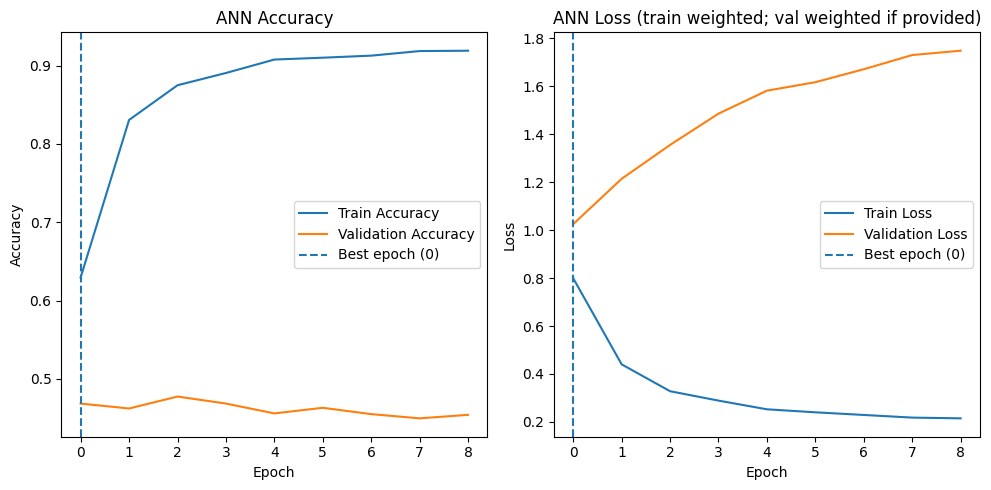

In [13]:
# Plot training and validation curves from the final training run
h = None
if 'history' in globals() and hasattr(history, 'history'):
    h = history.history
elif 'best_history' in globals() and best_history is not None and hasattr(best_history, 'history'):
    h = best_history.history

if h is None:
    raise RuntimeError("No Keras History object found. Make sure the training cell ran successfully.")

import numpy as np

best_epoch = int(np.argmin(h['val_loss'])) if 'val_loss' in h and len(h['val_loss']) else None

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(h.get('accuracy', []), label='Train Accuracy')
plt.plot(h.get('val_accuracy', []), label='Validation Accuracy')
if best_epoch is not None:
    plt.axvline(best_epoch, linestyle='--', label=f'Best epoch ({best_epoch})')
plt.title('ANN Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(h.get('loss', []), label='Train Loss')
plt.plot(h.get('val_loss', []), label='Validation Loss')
if best_epoch is not None:
    plt.axvline(best_epoch, linestyle='--', label=f'Best epoch ({best_epoch})')
plt.title('ANN Loss (train weighted; val weighted if provided)')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.tight_layout()
plt.show()


2025-09-23 22:14:42.741908: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-09-23 22:14:42.742221: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

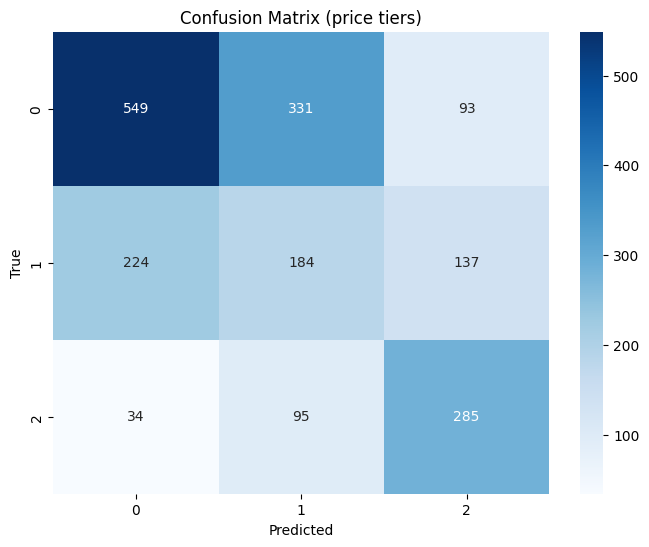

Classification report (price tiers):
              precision    recall  f1-score   support

           0       0.68      0.56      0.62       973
           1       0.30      0.34      0.32       545
           2       0.55      0.69      0.61       414

    accuracy                           0.53      1932
   macro avg       0.51      0.53      0.52      1932
weighted avg       0.55      0.53      0.53      1932

Test Accuracy: 0.5269
Macro F1:      0.5163
Best ANN configuration: {'num_layers': 1, 'units': 32, 'dropout_rate': 0.2, 'l2_reg': 0.0, 'learning_rate': 0.003}
Thresholds kept in-session: low=60.00, high=197.51
Persisted feature schema and thresholds to src/artifacts/price_model_metadata.json


In [14]:
y_pred_proba = model.predict(X_test_proc, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = y_test.to_numpy()

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_order, yticklabels=class_order)
plt.title('Confusion Matrix (price tiers)')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.show()

print("Classification report (price tiers):")
print(classification_report(y_true, y_pred, zero_division=0))
print(f"Test Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Macro F1:      {f1_score(y_true, y_pred, average='macro'):.4f}")
print(f"Best ANN configuration: {best_cfg}")
print(f"Thresholds kept in-session: low={low_thr:.2f}, high={high_thr:.2f}")

save_feature_metadata(
    ARTIFACTS_METADATA_PATH,
    categorical=cat_cols_effective,
    numerical=num_all,
    blocklist=BLOCKLIST_FEATURES,
    thresholds={'low': low_thr, 'high': high_thr},
    enabled=PERSIST_FEATURE_METADATA,
)
if PERSIST_FEATURE_METADATA:
    print(f"Persisted feature schema and thresholds to {ARTIFACTS_METADATA_PATH}")


## Grouped Cross-Validation (ANN)

In [15]:
num_folds = 5
gkf = GroupKFold(n_splits=num_folds)

acc_per_fold, f1_per_fold, loss_per_fold = [], [], []
for fold_no, (tr_idx, val_idx) in enumerate(gkf.split(X_all, None, groups=groups_all), start=1):
    X_tr_raw, X_val_raw = X_all.iloc[tr_idx], X_all.iloc[val_idx]
    price_tr = df['price'].iloc[tr_idx]
    price_val = df['price'].iloc[val_idx]

    low_f, high_f = compute_thresholds_from_train(price_tr)
    y_tr_f = bin_with_thresholds(price_tr, low_f, high_f)
    y_val_f = bin_with_thresholds(price_val, low_f, high_f)

    pre_fold = make_preprocessor(style="scale")
    X_tr = pre_fold.fit_transform(X_tr_raw)
    X_val = pre_fold.transform(X_val_raw)

    model_fold = build_ann(
        input_dim=X_tr.shape[1],
        num_layers=best_cfg['num_layers'],
        units=best_cfg['units'],
        dropout_rate=best_cfg['dropout_rate'],
        l2_reg=best_cfg['l2_reg'],
        learning_rate=best_cfg['learning_rate'],
        num_classes=len(class_order),
    )

    early_stop_cv = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    reduce_lr_cv  = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=0)

    model_fold.fit(
        X_tr, y_tr_f,
        epochs=200,
        validation_data=(X_val, y_val_f),
        callbacks=[early_stop_cv, reduce_lr_cv],
        verbose=0,
    )

    loss, acc = model_fold.evaluate(X_val, y_val_f, verbose=0)
    y_val_pred = np.argmax(model_fold.predict(X_val, verbose=0), axis=1)
    f1 = f1_score(y_val_f, y_val_pred, average='macro')

    print(f"Fold {fold_no}: Acc={acc*100:.2f}% | Loss={loss:.4f} | MacroF1={f1:.4f}")
    acc_per_fold.append(acc * 100)
    f1_per_fold.append(f1)
    loss_per_fold.append(loss)

print('\n' + '-'*72)
print('Grouped CV summary (unseen parts each fold):')
print(f"Accuracy: mean {np.mean(acc_per_fold):.2f}%  (+/- {np.std(acc_per_fold):.2f})")
print(f"Macro F1: mean {np.mean(f1_per_fold):.4f} (+/- {np.std(f1_per_fold):.4f})")
print(f"Loss:     mean {np.mean(loss_per_fold):.4f}")
print('-'*72)


Fold 1: Acc=48.43% | Loss=1.1370 | MacroF1=0.4801


2025-09-23 22:14:49.112996: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-09-23 22:14:49.113311: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Fold 2: Acc=36.02% | Loss=1.4360 | MacroF1=0.3484
Fold 3: Acc=51.18% | Loss=1.0221 | MacroF1=0.4623


2025-09-23 22:14:55.269520: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-09-23 22:14:55.269850: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Fold 4: Acc=55.42% | Loss=0.8775 | MacroF1=0.5358
Fold 5: Acc=55.51% | Loss=0.9374 | MacroF1=0.4931

------------------------------------------------------------------------
Grouped CV summary (unseen parts each fold):
Accuracy: mean 49.31%  (+/- 7.16)
Macro F1: mean 0.4639 (+/- 0.0627)
Loss:     mean 1.0820
------------------------------------------------------------------------


## Classical Model Benchmark

In [16]:
def fit_select_on_inner_classic(model_key, X_tr_raw, y_tr, groups_tr):
    # Carve an inner grouped validation split from outer-train to select hyperparams.
    inner = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
    inner_tr_idx, inner_val_idx = next(inner.split(X_tr_raw, y_tr, groups=groups_tr))

    X_inner_tr_raw = X_tr_raw.iloc[inner_tr_idx]
    X_inner_val_raw = X_tr_raw.iloc[inner_val_idx]
    y_inner_tr = y_tr.iloc[inner_tr_idx]
    y_inner_val = y_tr.iloc[inner_val_idx]

    spec = MODEL_ZOO[model_key]
    grid = GRIDS_CLASSIC[model_key]
    style = spec["style"]

    pre = make_preprocessor(style)
    X_inner_tr = pre.fit_transform(X_inner_tr_raw)
    X_inner_val = pre.transform(X_inner_val_raw)

    best_f1 = -np.inf
    best_params = None

    for params in grid_dict_product(grid):
        est = spec["factory"](params)
        est.fit(X_inner_tr, y_inner_tr)
        y_val_pred = est.predict(X_inner_val)
        f1 = f1_score(y_inner_val, y_val_pred, average="macro")
        if f1 > best_f1:
            best_f1 = f1
            best_params = params

    return best_params, best_f1

records = []

for key in MODEL_KEYS:
    label = MODEL_ZOO[key]["label"]
    print()
    print(f"=== {label} ({key}) ===")

    # Hyperparameter selection on a grouped inner split
    best_params, inner_f1 = fit_select_on_inner_classic(key, X_train_raw, y_train, groups_train)
    print(f"Selected params: {best_params} | Inner macro F1={inner_f1:.4f}")

    # Refit preprocessor on full outer-train, then train and evaluate
    pre = make_preprocessor(MODEL_ZOO[key]["style"])
    X_train_cls = pre.fit_transform(X_train_raw)
    X_test_cls  = pre.transform(X_test_raw)

    est = MODEL_ZOO[key]["factory"](best_params)
    est.fit(X_train_cls, y_train)

    y_pred_cls = est.predict(X_test_cls)
    acc = accuracy_score(y_test, y_pred_cls)
    f1m = f1_score(y_test, y_pred_cls, average="macro")

    print(f"Test Accuracy={acc:.4f} | Test Macro F1={f1m:.4f}")
    print(classification_report(y_test, y_pred_cls, zero_division=0))

    records.append(
        {
            "key": key,
            "model": label,
            "best_params": best_params,
            "inner_macro_f1": round(inner_f1, 4),
            "test_accuracy": round(acc, 4),
            "test_macro_f1": round(f1m, 4),
        }
    )



=== SVC (RBF) (svc_rbf) ===
Selected params: {'C': 1.0, 'gamma': 'auto'} | Inner macro F1=0.5055
Test Accuracy=0.4741 | Test Macro F1=0.4645
              precision    recall  f1-score   support

           0       0.61      0.50      0.55       973
           1       0.26      0.28      0.27       545
           2       0.50      0.67      0.57       414

    accuracy                           0.47      1932
   macro avg       0.46      0.48      0.46      1932
weighted avg       0.49      0.47      0.48      1932


=== LogisticRegression (logreg) ===
Selected params: {'C': 1.0, 'solver': 'lbfgs', 'max_iter': 2000} | Inner macro F1=0.5032
Test Accuracy=0.4348 | Test Macro F1=0.3893
              precision    recall  f1-score   support

           0       0.53      0.51      0.52       973
           1       0.21      0.11      0.15       545
           2       0.40      0.67      0.50       414

    accuracy                           0.43      1932
   macro avg       0.38      0.43  

In [17]:

results = pd.DataFrame.from_records(records)
results_sorted = results.sort_values([
    "test_macro_f1", "test_accuracy"
], ascending=False).reset_index(drop=True)

print("\n=== Ranked results (outer test) ===")
print(results_sorted[["model", "test_macro_f1", "test_accuracy", "inner_macro_f1", "best_params"]])



=== Ranked results (outer test) ===
                        model  test_macro_f1  test_accuracy  inner_macro_f1  \
0                   SVC (RBF)         0.4645         0.4741          0.5055   
1                  ExtraTrees         0.4358         0.4519          0.5523   
2    SGDClassifier (log_loss)         0.4342         0.4917          0.5223   
3  LinearDiscriminantAnalysis         0.4110         0.4115          0.3775   
4          LogisticRegression         0.3893         0.4348          0.5032   

                                         best_params  
0                        {'C': 1.0, 'gamma': 'auto'}  
1             {'n_estimators': 200, 'max_depth': 20}  
2  {'loss': 'log_loss', 'alpha': 0.001, 'max_iter...  
3                                  {'solver': 'svd'}  
4    {'C': 1.0, 'solver': 'lbfgs', 'max_iter': 2000}  


## Feature Leakage Audit

In [18]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupKFold
from sklearn.metrics import f1_score

def single_feature_cv_score(feature_name):
    # Build a tiny pipeline: transform only this feature, then multinomial logistic regression
    if feature_name in cat_cols_effective:
        try:
            ohe = Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
            ])
        except TypeError:
            ohe = Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
            ])
        pipe = Pipeline([('ohe', ohe),
                         ('clf', LogisticRegression(max_iter=200, multi_class='multinomial'))])
        X_feat = X_train_raw[[feature_name]]
    else:
        pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
            ('clf', LogisticRegression(max_iter=200, multi_class='multinomial'))
        ])
        X_feat = X_train_raw[[feature_name]]

    # Grouped CV by 'part' to simulate unseen parts
    gkf = GroupKFold(n_splits=5)
    f1_scores = []
    for tr_idx, val_idx in gkf.split(X_feat, y_train, groups=groups_train):
        X_tr, X_val = X_feat.iloc[tr_idx], X_feat.iloc[val_idx]
        price_tr = df['price'].iloc[tr_idx]
        price_val = df['price'].iloc[val_idx]
        low_f, high_f = compute_thresholds_from_train(price_tr)
        y_tr_f = bin_with_thresholds(price_tr, low_f, high_f)
        y_val_f = bin_with_thresholds(price_val, low_f, high_f)
        pipe.fit(X_tr, y_tr_f)
        y_val_pred = pipe.predict(X_val)
        f1_scores.append(f1_score(y_val_f, y_val_pred, average='macro'))
    return np.mean(f1_scores)

# Audit each feature (categorical + numeric) — target not included by construction
audit_results = []
for name in cat_cols_effective + num_all:
    score = single_feature_cv_score(name)
    audit_results.append((name, score))
audit_results.sort(key=lambda x: x[1], reverse=True)

# Warn-only to avoid blocking runs
suspicious = [(n, s) for n, s in audit_results if s >= LEAKAGE_F1_THRESHOLD]
if suspicious:
    print(f"WARNING: The following features individually exceeded the macro F1 threshold ({LEAKAGE_F1_THRESHOLD:.2f}):")
    for n, s in suspicious:
        print(f"  - {n}: macro F1={s:.4f}")
    print("Proceeding anyway per request to include all features except the target.")
else:
    worst_name, worst_score = audit_results[0]
    print(f"No single feature breached the threshold ({LEAKAGE_F1_THRESHOLD:.2f}). "
          f"Peak macro F1 = {worst_score:.4f} ({worst_name}).")


No single feature breached the threshold (0.85). Peak macro F1 = 0.2932 (car type).


## SHAP Explanations

In [19]:
import sys
import subprocess
import os
from pathlib import Path

def _ensure_import(module_name, pip_name=None):
    try:
        return __import__(module_name)
    except ModuleNotFoundError:
        pkg = pip_name or module_name
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg, '-q'])
        return __import__(module_name)

_ensure_import('numpy')
_ensure_import('pandas')
_ensure_import('sklearn', 'scikit-learn')

import numpy as np  # noqa: E402
import pandas as pd  # noqa: E402
from sklearn.model_selection import GroupShuffleSplit  # noqa: E402

# Re-load the price data and feature metadata for SHAP reuse
price_env = os.environ.get('PRICE_DATA_PATH', '').strip()
candidates = [Path(p) for p in [price_env] if p] + [
    Path("data") / "Price.csv",
    Path("..") / "data" / "Price.csv",
]
file_path = next((p for p in candidates if p.exists()), None)
if file_path is None:
    raise FileNotFoundError("Could not find Price.csv for SHAP reuse.")

df_price = pd.read_csv(file_path)
df_price.columns = df_price.columns.str.strip()
df_price['price'] = pd.to_numeric(df_price['price'], errors='coerce')

# Coerce numeric columns in the SHAP copy too
numeric_cols_force = [
    'number of cars in jordan',
    'car age',
    'failure rate',
    'price of the car',
    'repair or replacement cost',
    'car total maintenance cost average',
    'critically',
    'online price',
    'price',
]
for c in numeric_cols_force:
    if c in df_price.columns:
        df_price[c] = pd.to_numeric(df_price[c], errors='coerce')
df_price.replace([np.inf, -np.inf], np.nan, inplace=True)

# Load saved feature metadata
metadata = load_feature_metadata(ARTIFACTS_METADATA_PATH)

cat_cols_effective = metadata['feature_schema']['categorical']
num_all = metadata['feature_schema']['numerical']

X_all_price = df_price[cat_cols_effective + num_all].copy()
groups_all_price = df_price['part'].astype(str)

_gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
train_idx_shap, test_idx_shap = next(_gss.split(X_all_price, None, groups=groups_all_price))

X_train_raw_shap = X_all_price.iloc[train_idx_shap]
X_test_raw_shap = X_all_price.iloc[test_idx_shap]

X_train_proc_shap = preprocessor.transform(X_train_raw_shap).astype("float32")
X_test_proc_shap  = preprocessor.transform(X_test_raw_shap).astype("float32")

print('Reused in-memory model and preprocessor for SHAP computation.')
print('  X_train_proc shape:', getattr(X_train_proc_shap, 'shape', None))
print('  X_test_proc shape :', getattr(X_test_proc_shap, 'shape', None))


Reused in-memory model and preprocessor for SHAP computation.
  X_train_proc shape: (5720, 51)
  X_test_proc shape : (1932, 51)


In [20]:

def get_feature_names(preprocessor):
    try:
        names = preprocessor.get_feature_names_out()
        return [str(n).replace('num_skew__', '').replace('num__', '').replace('cat__', '') for n in names]
    except Exception:
        names = []
        for name, trans, cols in preprocessor.transformers_:
            if name == 'remainder' and trans == 'drop':
                continue
            if name in ('num_skew', 'num'):
                names.extend(list(cols))
            elif name == 'cat':
                try:
                    ohe = trans.named_steps.get('ohe')
                    categories = ohe.categories_
                    for col, cats in zip(cols, categories):
                        for cat in cats:
                            names.append(f'{col}={cat}')
                except Exception:
                    names.extend(list(cols))
            else:
                if isinstance(cols, list):
                    names.extend(list(cols))
        return names

feature_names = get_feature_names(preprocessor)
print('n_features:', len(feature_names))
print('first 10:', feature_names[:10])


n_features: 51
first 10: ['number of cars in jordan', 'failure rate', 'repair or replacement cost', 'critically', 'price of the car', 'car age', 'car total maintenance cost average', 'car type=1', 'car type=2', 'car type=3']


In [21]:

import platform

rng = np.random.RandomState(SEED)
X_bg = X_train_proc_shap
X_eval = X_test_proc_shap if 'X_test_proc_shap' in globals() else X_train_proc_shap

bg_size = min(100, X_bg.shape[0])
explain_size = min(200, X_eval.shape[0])
bg_idx = rng.choice(X_bg.shape[0], size=bg_size, replace=False)
explain_idx = rng.choice(X_eval.shape[0], size=explain_size, replace=False)

background = X_bg[bg_idx]
X_explain = X_eval[explain_idx]

if hasattr(background, 'toarray'):
    background = background.toarray()
if hasattr(X_explain, 'toarray'):
    X_explain = X_explain.toarray()


def _run_kernel_explainer(nsamples=100):
    f = lambda x: model.predict(x, verbose=0)
    explainer_loc = shap.KernelExplainer(f, background)
    values = explainer_loc.shap_values(X_explain, nsamples=nsamples)
    return explainer_loc, values

prefer_kernel = (platform.system() == 'Darwin' and platform.machine().lower().startswith('arm'))

if prefer_kernel:
    print('Using KernelExplainer on Apple Silicon for stability.')
    explainer, shap_values = _run_kernel_explainer()
    method = 'KernelExplainer'
else:
    try:
        explainer = shap.DeepExplainer(model, background)
        shap_values = explainer.shap_values(X_explain)
        method = 'DeepExplainer'
    except Exception as err:
        print('DeepExplainer failed, falling back to KernelExplainer:', err)
        explainer, shap_values = _run_kernel_explainer()
        method = 'KernelExplainer'

print('SHAP explainer:', method)

_shap_values = shap_values
_X_explain = X_explain
_background = background


Using KernelExplainer on Apple Silicon for stability.


NameError: name 'shap' is not defined

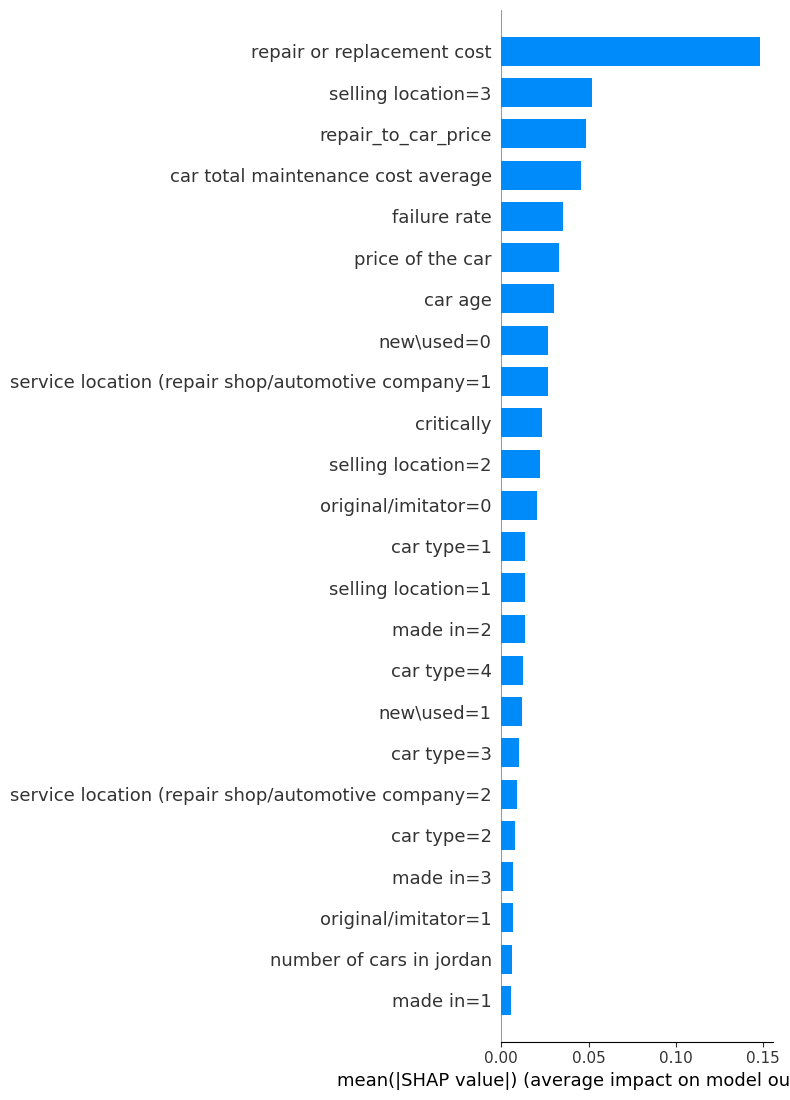

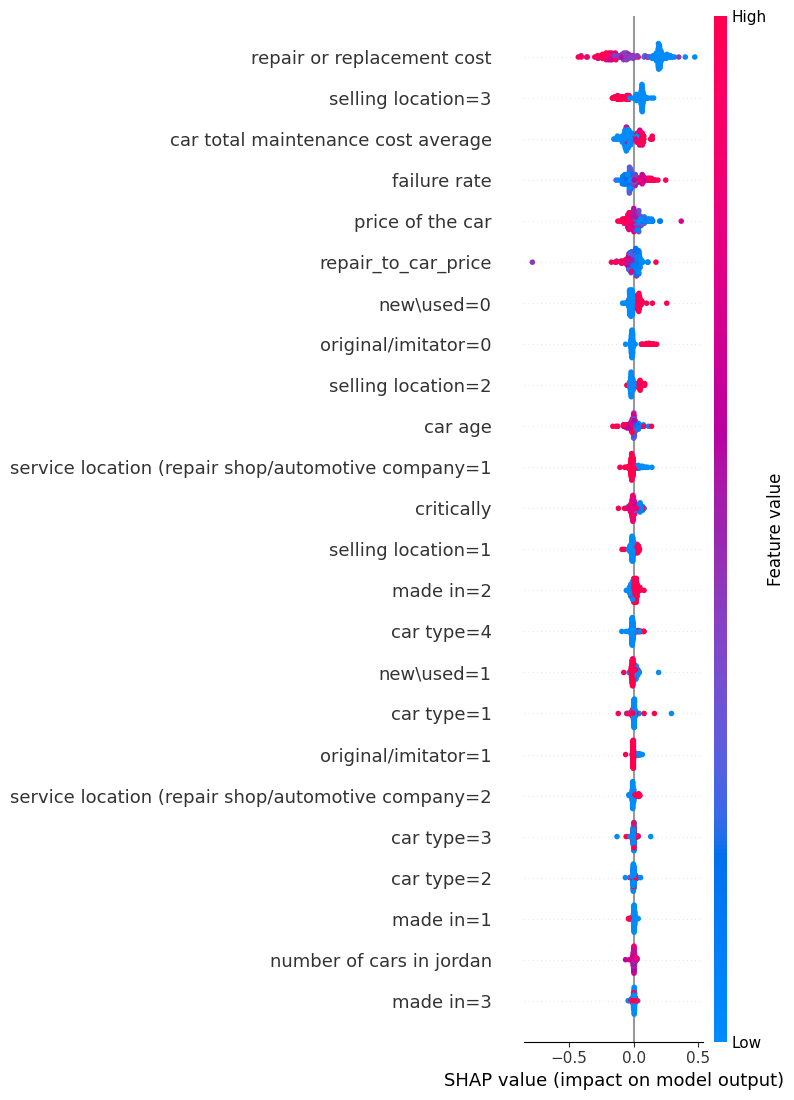

Displayed SHAP beeswarm plot for low_price; top features listed above (not saved).


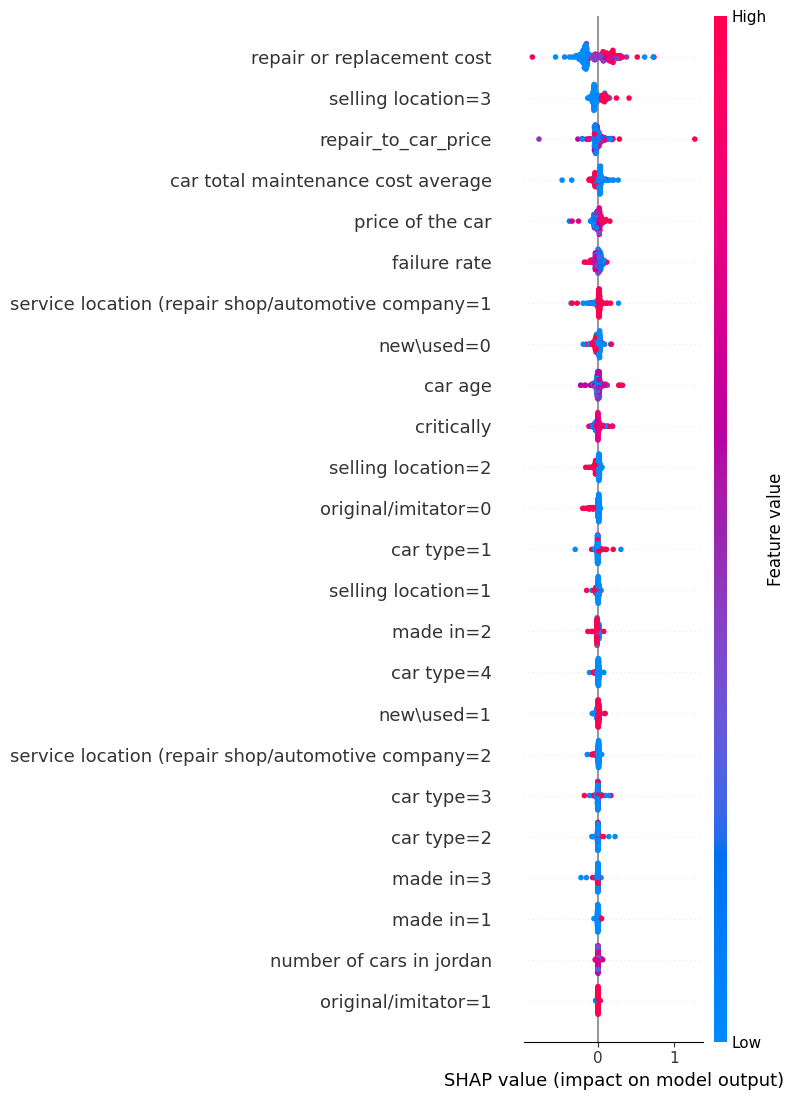

Displayed SHAP beeswarm plot for high_price; top features listed above (not saved).
Displayed SHAP summary plot and feature importance details in notebook (saved to figures/).
Saved files:
figures\price_shap_summary.png
figures\price_shap_low_price.png
figures\price_shap_high_price.png


In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

figures_dir = Path('figures')
figures_dir.mkdir(exist_ok=True)

sv_raw = _shap_values
X_explain = _X_explain.toarray() if hasattr(_X_explain, 'toarray') else _X_explain

if isinstance(sv_raw, list):
    shap_array = np.stack([np.array(s) for s in sv_raw], axis=-1)
else:
    shap_array = np.array(sv_raw)
    if shap_array.ndim == 2:
        shap_array = shap_array[..., np.newaxis]

_shap_array = shap_array
shap_abs = np.abs(shap_array).mean(axis=-1)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_abs, X_explain, feature_names=feature_names, plot_type='bar', show=False, max_display=25)
plt.tight_layout()
summary_path = figures_dir / 'price_shap_summary.png'
plt.savefig(summary_path, dpi=300, bbox_inches='tight')
plt.show()

class_order = globals().get('class_order', list(range(shap_array.shape[-1])))
class_indices = {cls: idx for idx, cls in enumerate(class_order) if idx < shap_array.shape[-1]}
target_classes = {
    'low_price': 0,
    'high_price': 2,
}

for label, cls_id in target_classes.items():
    if cls_id not in class_indices:
        continue
    cls_idx = class_indices[cls_id]
    shap_class = shap_array[..., cls_idx]

    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_class, X_explain, feature_names=feature_names, show=False, max_display=25)
    plt.tight_layout()
    beeswarm_path = figures_dir / f'price_shap_{label}.png'
    plt.savefig(beeswarm_path, dpi=300, bbox_inches='tight')
    plt.show()

    vals_cls = np.abs(shap_class).mean(axis=0)
    fi_cls = pd.Series(vals_cls, index=feature_names).sort_values(ascending=False)
    print(f"Displayed SHAP beeswarm plot for {label}; top features listed above (not saved).")

vals = shap_abs.mean(axis=0)
fi = pd.Series(vals, index=feature_names).sort_values(ascending=False)
print('Displayed SHAP summary plot and feature importance details in notebook (saved to figures/).')
print('Saved files:')
print(summary_path)
for label in target_classes:
    print(figures_dir / f'price_shap_{label}.png')


In [22]:
# git_diag.py
import os, subprocess, sys, shutil

def run(cmd):
    try:
        out = subprocess.check_output(cmd, stderr=subprocess.STDOUT, shell=True, text=True)
        return 0, out.strip()
    except subprocess.CalledProcessError as e:
        return e.returncode, e.output.strip()

def header(title):
    print("\n" + "="*len(title))
    print(title)
    print("="*len(title))

def main():
    header("BASIC")
    print("CWD:", os.getcwd())
    rc, git_ver = run("git --version")
    print("git --version:", git_ver if rc == 0 else f"ERR({rc}) {git_ver}")

    rc, inside = run("git rev-parse --is-inside-work-tree")
    if rc != 0 or inside != "true":
        print("\nNot a git repo here. If this is the wrong folder, open the repo root in VS Code.")
        sys.exit(1)

    rc, branch = run("git rev-parse --abbrev-ref HEAD")
    print("branch:", branch if rc == 0 else f"ERR({rc}) {branch}")

    header("REMOTES")
    rc, remotes = run("git remote -v")
    print(remotes if remotes else "(no remotes)")

    header("STATUS (porcelain)")
    rc, status = run("git status --porcelain=v2 -b")
    print(status)

    header("AHEAD/BEHIND vs upstream")
    rc, upstream = run("git rev-parse --abbrev-ref --symbolic-full-name @{u}")
    if rc == 0:
        print("upstream:", upstream)
        rc2, diverge = run("git rev-list --left-right --count @{u}...HEAD")
        if rc2 == 0:
            left, right = diverge.split()
            print(f"behind {left}, ahead {right}")
        else:
            print("divergence: ERR", diverge)
    else:
        print("upstream: (none)")

    header("UNTRACKED FILES")
    rc, untracked = run("git ls-files --others --exclude-standard")
    print(untracked if untracked else "(none)")

    header("UNSTAGED CHANGES")
    rc, unstaged = run("git diff --name-status")
    print(unstaged if unstaged else "(none)")

    header("STAGED CHANGES")
    rc, staged = run("git diff --cached --name-status")
    print(staged if staged else "(none)")

    header("MERGE/REBASE STATE")
    rc, merging = run("git rev-parse -q --verify MERGE_HEAD")
    print("merging:", "yes" if rc == 0 else "no")
    rc, rebase_dir = run("git rev-parse --git-path rebase-merge")
    print("rebase in progress:", "yes" if rebase_dir and os.path.exists(rebase_dir) else "no")

    header("LAST 5 COMMITS")
    rc, log = run("git log --oneline --decorate -n 5")
    print(log if rc == 0 else "(no commits yet)")

if __name__ == "__main__":
    main()



=====
BASIC
=====
CWD: /Users/yaeesh/hev-spareparts-ml/src
git --version: git version 2.39.5 (Apple Git-154)
branch: main

REMOTES
origin	https://github.com/Oyaeesh/hev-spareparts-ml.git (fetch)
origin	https://github.com/Oyaeesh/hev-spareparts-ml.git (push)

STATUS (porcelain)
# branch.oid fd6442247deb34f9dd9f6c399c1ccc20bf1dee2a
# branch.head main
# branch.upstream origin/main
# branch.ab +0 -0
1 M. N... 100644 100644 100644 d2c5731eb946945e6aa4b0bdbc82a60e8e518bb0 b0efe73e1156524c434dc15004c364d318eb4d92 ../data/Price.csv
1 MM N... 100644 100644 100644 d8896bdcc2dca029d77b02e2013a18ea2bd606d1 75eaa6114fb5b9615e2a71e904407ad693c1defd HEV-SpareParts-Price-Classification.ipynb
1 A. N... 000000 100644 100644 0000000000000000000000000000000000000000 67f3f4a863647eb0f13a508de3af13e06e496edc best_ann.keras
1 A. N... 000000 100644 100644 0000000000000000000000000000000000000000 ef6db5237c051aea1df940e1cdc0feec2fe10258 src/artifacts/price_model_metadata.json

AHEAD/BEHIND vs upstream
upstrea